# Multiclass Classification

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mbarbetti/lymphoma-classification/blob/master/4_multi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/lymphoma-classification/blob/master/4_multi_classification.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection  import StratifiedShuffleSplit
from sklearn.preprocessing    import MinMaxScaler
from imblearn.over_sampling   import SMOTE
from sklearn.dummy            import DummyClassifier
from sklearn.linear_model     import LogisticRegression
from sklearn.svm              import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble         import RandomForestClassifier, GradientBoostingClassifier

from utils import custom_predictions, plot_clf_region, multiclass_promo, plot_conf_matrices

LABELS = ["cHL", "GZL", "PMBCL"]

## Data loading and preparation

In [2]:
data_dir  = "./data"
data_file = "db_mediastinalbulky_reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data.query("lymphoma_type == 2") . info()   # Gray-zone instances

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 81 to 89
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ID                                    9 non-null      float64
 1   lymphoma_type                         9 non-null      float64
 2   CONVENTIONAL_SUVbwmidpoint            9 non-null      float64
 3   CONVENTIONAL_SUVbwmean                9 non-null      float64
 4   CONVENTIONAL_TLG(mL)[onlyForPETorNM]  9 non-null      float64
 5   CONVENTIONAL_SUVbwSkewness            9 non-null      float64
 6   CONVENTIONAL_SUVbwKurtosis            9 non-null      float64
 7   GLCM_Homogeneity[=InverseDifference]  9 non-null      float64
 8   GLCM_Entropy_log10                    9 non-null      float64
 9   GLRLM_SRE                             9 non-null      float64
 10  GLRLM_LRE                             9 non-null      float64
 11  GLZLM_LGZE           

### Input/output preparation

In [3]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

X  = data.query("lymphoma_type != 2")[X_cols] . to_numpy()
y  = data.query("lymphoma_type != 2")[y_cols] . to_numpy() . flatten()
y  = ( y == 3 )   # PMBCL/cHL classification

ratio_0 = len(y[y == True]) / len(y[y == False])
print ( "PMBCL-cHL ratio on data-set : {:.1f}%" . format (100 * ratio_0) )

PMBCL-cHL ratio on data-set : 35.8%


In [4]:
X_gz = data.query("lymphoma_type == 2")[X_cols] . to_numpy()
y_gz = data.query("lymphoma_type == 2")[y_cols] . to_numpy() . flatten()

ratio_1 = len(y_gz) / len(y[y == True])
print ( "GZL-PMBCL ratio on data-set : {:.1f}%" . format (100 * ratio_1) )

ratio_2 = len(y_gz) / len(y[y == False])
print ( "GZL-cHL ratio on data-set : {:.1f}%" . format (100 * ratio_2) )

GZL-PMBCL ratio on data-set : 31.0%
GZL-cHL ratio on data-set : 11.1%


### Train-set and test-set splitting

In [5]:
sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.3 )
for idx_train, idx_test in sss . split ( X, y ):
  X_train , y_train = X[idx_train] , y[idx_train]
  X_test  , y_test  = X[idx_test]  , y[idx_test] 

In [16]:
## Train-set expansion
X_train_comb = np.concatenate ( [ X_train, X_gz ] )
y_train_comb = np.concatenate ( [ np.where(y_train, 3, 1), y_gz ] )

## Test-set expansion
X_test_comb = np.concatenate ( [ X_test, X_gz ] )
y_test_comb = np.concatenate ( [ np.where(y_test, 3, 1), y_gz ] )

### Data preprocessing

In [7]:
scaler = MinMaxScaler()

X_train_original = X_train

X_train = scaler . fit_transform ( X_train )
X_test  = scaler . transform ( X_test )

print ( f"Resulting mean on train-set : {np.mean(X_train, axis = 0)}" )
print ( f"Resulting mean on test-set  : {np.mean(X_test, axis = 0)}" )

Resulting mean on train-set : [0.37272696 0.30150491 0.17826397 0.23710496 0.05727749 0.35626364
 0.60560985 0.71593966 0.23892358 0.29729916 0.2359059 ]
Resulting mean on test-set  : [0.36919496 0.30006454 0.21031709 0.2534261  0.05428993 0.3842411
 0.59733586 0.69096999 0.25800775 0.32146688 0.25292195]


In [8]:
sm = SMOTE()   # oversampling technique
X_train_res, y_train_res = sm.fit_resample ( X_train , y_train )

In [9]:
X_gz = scaler . transform ( X_gz  )
X_train_comb = scaler . transform ( X_train_comb )
X_test_comb  = scaler . transform ( X_test_comb  )

In [21]:
print ( np.mean (X_gz, axis = 0) )
print ( np.mean (X_train_comb, axis = 0) )
print ( np.mean (X_test_comb, axis = 0) )

[0.4847272  0.37912748 0.30093482 0.22168606 0.0388159  0.26838363
 0.70039868 0.8061791  0.14996751 0.22333333 0.30984729]
[0.38444792 0.30962821 0.19110161 0.23549135 0.05534546 0.34706689
 0.61552961 0.72538333 0.22961423 0.28955855 0.24364395]
[0.39395187 0.3170066  0.22973518 0.24662466 0.05097407 0.3594145
 0.61942075 0.71565765 0.23485627 0.30043826 0.26512023]


## Logistic regression

In [23]:
clf_logreg = LogisticRegression()
clf_logreg . fit ( X_train_res, y_train_res )

logreg_scores_train = clf_logreg . predict_proba ( X_train )
y_pred_train_logreg, th_logreg = custom_predictions ( y_true   = y_train , 
                                                      y_scores = logreg_scores_train , 
                                                      recall_score    = 0.8  , 
                                                      precision_score = None ,
                                                      show_curves = False , 
                                                      save_figure = False )

logreg_scores_gz = clf_logreg . predict_proba (X_gz)
y_pred_train_gz  = ( logreg_scores_gz[:,1] > th_logreg )

len(np.nonzero(y_pred_train_gz)[0]) / len(X_gz)   # GZL = uncertainty btw {cHL, PMBCL} 

0.6666666666666666

In [24]:
logreg_scores_train_comb = np.concatenate ( [ logreg_scores_train, logreg_scores_gz ] )

logreg_scores_test = clf_logreg . predict_proba ( X_test )
logreg_scores_test_comb  = np.concatenate ( [ logreg_scores_test , logreg_scores_gz ] )

In [25]:
def get_boundaries ( scores : np.ndarray , threshold : float , limits : float = 0.5 ):
  """Returns the custom boundaries for GZL predictions."""
  hist, bound = np.histogram ( scores[:,1], bins = 20 )
  cumsum  = np.cumsum ( hist.astype(np.float32) )
  cumsum /= cumsum[-1]

  x = ( bound[1:] + bound[:-1] ) / 2   # bin centers
  y = np.interp ( threshold, x, cumsum )   # cumulative value of custom threshold

  y_min = y - limits
  x_min = np.interp (y_min, cumsum, x)

  y_max = y + limits
  x_max = np.interp (y_max, cumsum, x)

  return x_min, x_max

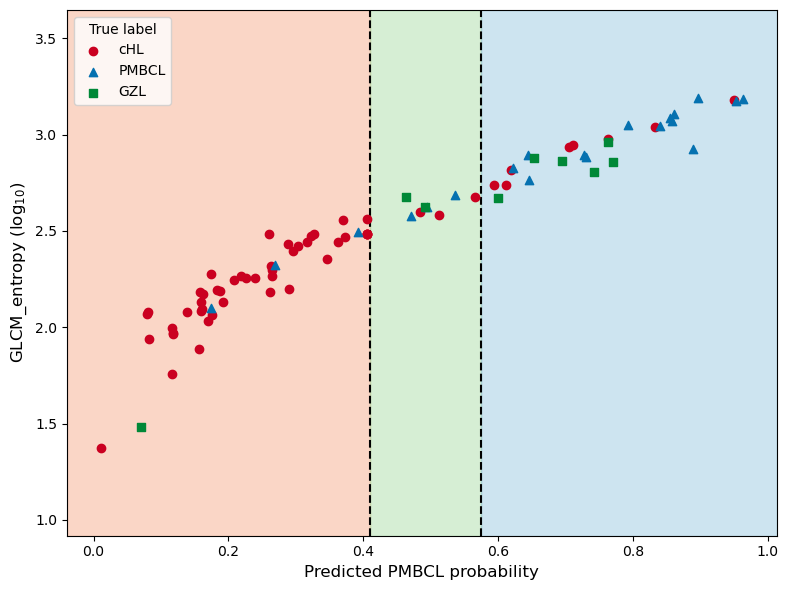

In [26]:
plot_clf_region ( y_true   = y_train_comb , 
                  y_scores = logreg_scores_train_comb ,
                  X_feat    = scaler . inverse_transform (X_train_comb) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( logreg_scores_train, th_logreg, 0.5*len(y_gz)/len(y_train_comb) ) , 
                  labels = LABELS , 
                  save_figure = False )

#### Performance on train-set

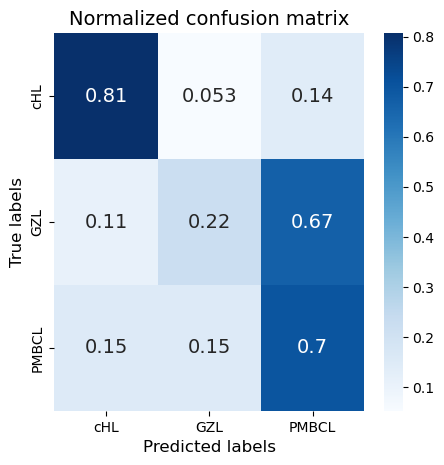

In [15]:
conf_matrix = multiclass_promo ( y_true = y_train_comb , 
                                 y_scores = logreg_scores_train_comb , 
                                 boundaries = get_boundaries (logreg_scores_train, th_logreg, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

#### Performance on test-set

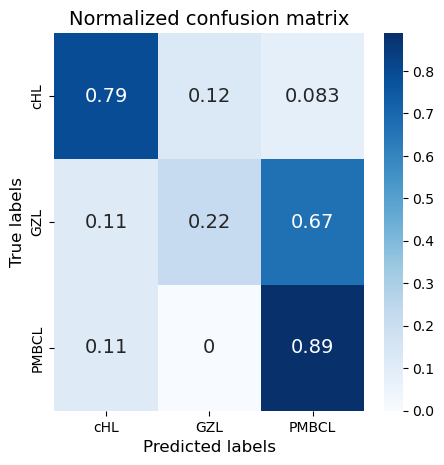

In [29]:
conf_matrix = multiclass_promo ( y_true = y_test_comb , 
                                 y_scores = logreg_scores_test_comb , 
                                 boundaries = get_boundaries (logreg_scores_train, th_logreg, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

## Linear SVM

In [31]:
clf_linsvm = SVC ( kernel = "linear", probability = True )
clf_linsvm . fit ( X_train_res, y_train_res )

linsvm_scores_train = clf_linsvm . predict_proba ( X_train )
y_pred_train_linsvm, th_linsvm = custom_predictions ( y_true   = y_train , 
                                                      y_scores = linsvm_scores_train , 
                                                      recall_score    = 0.8  , 
                                                      precision_score = None ,
                                                      show_curves = False , 
                                                      save_figure = False )

linsvm_scores_gz = clf_linsvm . predict_proba (X_gz)
y_pred_train_gz  = ( linsvm_scores_gz[:,1] > th_linsvm )

len(np.nonzero(y_pred_train_gz)[0]) / len(X_gz)   # GZL = uncertainty btw {cHL, PMBCL} 

0.6666666666666666

In [32]:
linsvm_scores_train_comb = np.concatenate ( [ linsvm_scores_train, linsvm_scores_gz ] )

linsvm_scores_test = clf_linsvm . predict_proba ( X_test )
linsvm_scores_test_comb  = np.concatenate ( [ linsvm_scores_test , linsvm_scores_gz ] )

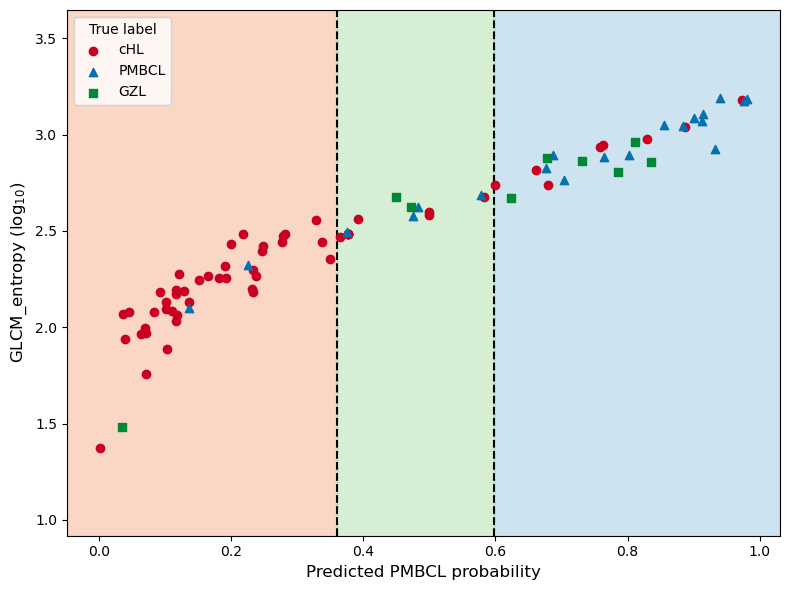

In [33]:
plot_clf_region ( y_true   = y_train_comb , 
                  y_scores = linsvm_scores_train_comb ,
                  X_feat    = scaler . inverse_transform (X_train_comb) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( linsvm_scores_train, th_linsvm, 0.5*len(y_gz)/len(y_train_comb) ) , 
                  labels = LABELS , 
                  save_figure = False )

#### Performance on train-set

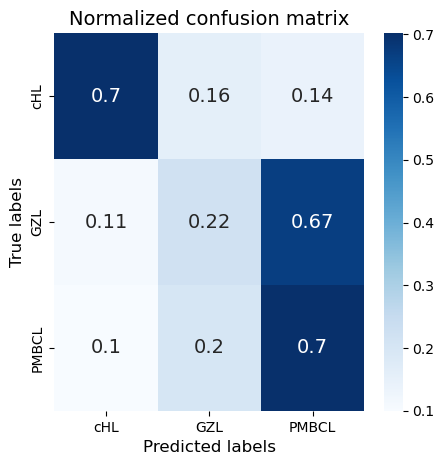

In [34]:
conf_matrix = multiclass_promo ( y_true = y_train_comb , 
                                 y_scores = linsvm_scores_train_comb , 
                                 boundaries = get_boundaries (linsvm_scores_train, th_linsvm, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

#### Performance on test-set

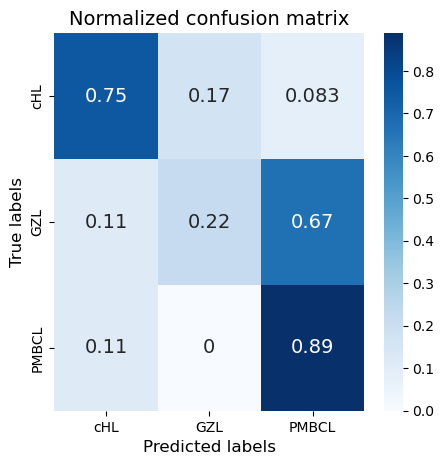

In [35]:
conf_matrix = multiclass_promo ( y_true = y_test_comb , 
                                 y_scores = linsvm_scores_test_comb , 
                                 boundaries = get_boundaries (linsvm_scores_train, th_linsvm, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

## Gaussian process

In [ ]:
clf_gausproc = GaussianProcessClassifier()
clf_gausproc . fit ( X_train_res, y_train_res )

gausproc_scores = clf_gausproc . predict_proba ( X_train )
y_pred_gausproc, th_gausproc = custom_predictions ( y_true   = y_train , 
                                                    y_scores = gausproc_scores , 
                                                    recall_score    = 0.8  , 
                                                    precision_score = None ,
                                                    show_curves = False , 
                                                    save_figure = False )

In [ ]:
gausproc_scores_gz = clf_gausproc . predict_proba (X_gz)
gausproc_scores_exp = np.concatenate ( [ gausproc_scores, gausproc_scores_gz ] )

In [ ]:
plot_clf_region ( y_true   = y_train_exp , 
                  y_scores = gausproc_scores_exp ,
                  X_feat    = scaler . inverse_transform (X_train) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( gausproc_scores, th_gausproc, 0.5*len(y_gz)/len(y_train_exp) ) , 
                  labels = LABELS , 
                  save_figure = False )

## Random forest

In [ ]:
clf_rndfrs = RandomForestClassifier ( n_estimators = 100, max_depth = 1 )
clf_rndfrs . fit ( X_train_res, y_train_res )

rndfrs_scores = clf_rndfrs . predict_proba ( X_train )
y_pred_rndfrs, th_rndfrs = custom_predictions ( y_true   = y_train , 
                                                y_scores = rndfrs_scores , 
                                                recall_score    = 0.8  , 
                                                precision_score = None ,
                                                show_curves = False , 
                                                save_figure = False )

In [ ]:
rndfrs_scores_gz = clf_rndfrs . predict_proba (X_gz)
rndfrs_scores_exp = np.concatenate ( [ rndfrs_scores, rndfrs_scores_gz ] )

In [ ]:
plot_clf_region ( y_true   = y_train_exp , 
                  y_scores = rndfrs_scores_exp ,
                  X_feat    = scaler . inverse_transform (X_train) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( rndfrs_scores, th_rndfrs, 0.5*len(y_gz)/len(y_train_exp) ) , 
                  labels = LABELS , 
                  save_figure = False )

## Gradient BDT

In [ ]:
clf_gradbdt = GradientBoostingClassifier ( learning_rate = 0.2, n_estimators = 100, max_depth = 1 )
clf_gradbdt . fit ( X_train_res, y_train_res )

gradbdt_scores = clf_gradbdt . predict_proba ( X_train )
y_pred_gradbdt, th_gradbdt = custom_predictions ( y_true   = y_train , 
                                                  y_scores = gradbdt_scores , 
                                                  recall_score    = 0.8  , 
                                                  precision_score = None ,
                                                  show_curves = False , 
                                                  save_figure = False )

In [ ]:
gradbdt_scores_gz = clf_gradbdt . predict_proba (X_gz)
gradbdt_scores_exp = np.concatenate ( [ gradbdt_scores, gradbdt_scores_gz ] )

In [ ]:
plot_clf_region ( y_true   = y_train_exp , 
                  y_scores = gradbdt_scores_exp ,
                  X_feat    = scaler . inverse_transform (X_train) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( gradbdt_scores, th_gradbdt, 0.5*len(y_gz)/len(y_train_exp) ) , 
                  labels = LABELS , 
                  save_figure = False )